# Remote Sensing for Pastoralists in Garissa County
This notebook contains the code required to pull NDVI, color, and cloud data from sentinel hub. Additionally, it contains the code to create TIFF, png, and HTML outputs for visualization of this data.

### Prerequisites:
- A sentinel hub account

In [5]:
import getpass
import itertools
import json
import os
import tempfile
from pathlib import Path

import folium
from folium import raster_layers

import matplotlib.pyplot as plt
from matplotlib import colormaps

import numpy as np
from PIL import Image
from shapely.geometry import MultiLineString, MultiPolygon, Polygon, box, shape

import rasterio
from rasterio.merge import merge
from rasterio.plot import show
from rasterio.transform import from_bounds, xy

import cartopy.crs as ccrs

from sentinelhub import (
    SHConfig,
    CRS,
    BBox,
    BBoxSplitter,
    CustomGridSplitter,
    SentinelHubCatalog,
    DataCollection,
    MimeType,
    MosaickingOrder,
    OsmSplitter,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    TileSplitter,
    UtmGridSplitter,
    UtmZoneSplitter,
    read_data,
)

In [6]:
# Bounding Box: ((min_x, min_y), (max_x, max_y))- lat long format
# split bounding box is for breaking down the area of interest into smallers areas for parallel computation

kenya_bb = BBox((39.02616878748726, -0.1731641174991017, 39.20583121251274,0.006498117499101688), CRS.WGS84)
kenya_split = BBoxSplitter([kenya_bb], CRS.WGS84, (2, 2))

In [17]:
# Configuration for sentinel hub API connection
config = SHConfig()
config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
config.save("cdse")

Enter your SentinelHub client id ········
Enter your SentinelHub client secret ········


In [7]:
# Declaration of sentinel hub config
config = SHConfig("cdse")

In [8]:
# Configuration options for pulling data from sentinel hub. Each returns data in a different format for computation

# NDVI visualization script - TIFF return
NDVI_script = '''
    //VERSION=3
    function setup() {
    return {
        input: ["B04", "B08", 'SCL'],
        output: {
            bands: 1,
            sampleType: "FLOAT32"
            }
        };
    }

    function evaluatePixel(samples) {
        const clouds_or_water = [0, 3, 6, 7, 8, 9, 10];
        if (clouds_or_water.includes(samples.SCL)) {
            return [-1]
        }
        return [index(samples.B08, samples.B04)]
    }
    '''

# cloud visualization script - TIFF return
cloud_script = '''
    //VERSION=3
    function setup() {
    return {
        input: ['SCL'],
        output: {
            bands: 1,
            sampleType: "FLOAT32"
            }
        };
    }

    function evaluatePixel(samples) {
        const clouds_or_water = [8, 9];
        if (clouds_or_water.includes(samples.SCL)) {
            return [1]
        }
        return [0]
    }
    '''

# nir band visualization - PNG return
nir_script = '''
    //VERSION=3
function setup() {
    return {
        input: ["B08", "SCL", "dataMask"],
        output: {
            bands: 4,
            sampleType: "UINT8"
        }
    };
}

function evaluatePixel(samples) {
    const clouds_or_water = [8, 9, 10];
    if (clouds_or_water.includes(samples.SCL)) {
        return [0, 0, 0, 0];  // fully transparent for clouds/water
    }
    // scale B08 to 0-255 and round
    let b08_scaled = Math.round(samples.B08 * 255.0);
    if (b08_scaled > 255) b08_scaled = 255;
    if (b08_scaled < 0) b08_scaled = 0;

    return [b08_scaled, 0, 0, samples.dataMask ? 255 : 0]; // RGBA output
}

    '''
# red band visualization - PNG return
red_script = '''
    //VERSION=3
function setup() {
    return {
        input: ["B04", "SCL", "dataMask"],
        output: {
            bands: 4,
            sampleType: "UINT8"
        }
    };
}

function evaluatePixel(samples) {
    const clouds_or_water = [8, 9, 10];
    if (clouds_or_water.includes(samples.SCL)) {
        return [0, 0, 0, 0];  // fully transparent for clouds/water
    }
    // scale B04 to 0-255 and round
    let b04_scaled = Math.round(samples.B04 * 255.0);
    if (b04_scaled > 255) b04_scaled = 255;
    if (b04_scaled < 0) b04_scaled = 0;

    return [b04_scaled, 0, 0, samples.dataMask ? 255 : 0]; // RGBA output
}

    '''

# enhanced coloring sourced from sentinel hub - PNG return
color_script = '''
    //VERSION=3
    function setup() {
  return {
    input: ["B04", "B03", "B02", "dataMask"],
    output: { bands: 4 }
  };
}

// Contrast enhance / highlight compress


const maxR = 3.0; // max reflectance

const midR = 0.13;
const sat = 1.2;
const gamma = 1.8;

function evaluatePixel(smp) {
  const rgbLin = satEnh(sAdj(smp.B04), sAdj(smp.B03), sAdj(smp.B02));
  return [sRGB(rgbLin[0]), sRGB(rgbLin[1]), sRGB(rgbLin[2]), smp.dataMask];
}

function sAdj(a) {
  return adjGamma(adj(a, midR, 1, maxR));
}

const gOff = 0.01;
const gOffPow = Math.pow(gOff, gamma);
const gOffRange = Math.pow(1 + gOff, gamma) - gOffPow;

function adjGamma(b) {
  return (Math.pow((b + gOff), gamma) - gOffPow) / gOffRange;
}

// Saturation enhancement

function satEnh(r, g, b) {
  const avgS = (r + g + b) / 3.0 * (1 - sat);
  return [clip(avgS + r * sat), clip(avgS + g * sat), clip(avgS + b * sat)];
}

function clip(s) {
  return s < 0 ? 0 : s > 1 ? 1 : s;
}

//contrast enhancement with highlight compression

function adj(a, tx, ty, maxC) {
  var ar = clip(a / maxC, 0, 1);
  return ar * (ar * (tx / maxC + ty - 1) - ty) / (ar * (2 * tx / maxC - 1) - tx / maxC);
}

const sRGB = (c) => c <= 0.0031308 ? (12.92 * c) : (1.055 * Math.pow(c, 0.41666666666) - 0.055);
    '''

# Addition of cloud layer masking onto color script - PNG return
color_cloud_script = '''
    //VERSION=3
    function setup() {
  return {
    input: ["B04", "B03", "B02", "dataMask", "SCL"],
    output: { bands: 4 }
  };
}

// Contrast enhance / highlight compress


const maxR = 3.0; // max reflectance

const midR = 0.13;
const sat = 1.2;
const gamma = 1.8;

function evaluatePixel(smp) {
  const rgbLin = satEnh(sAdj(smp.B04), sAdj(smp.B03), sAdj(smp.B02));
  const clouds_or_water = [8, 9, 10];
    if (clouds_or_water.includes(smp.SCL)) {
        return [255,0,0,smp.dataMask]
    }
  return [sRGB(rgbLin[0]), sRGB(rgbLin[1]), sRGB(rgbLin[2]), smp.dataMask];
}

function sAdj(a) {
  return adjGamma(adj(a, midR, 1, maxR));
}

const gOff = 0.01;
const gOffPow = Math.pow(gOff, gamma);
const gOffRange = Math.pow(1 + gOff, gamma) - gOffPow;

function adjGamma(b) {
  return (Math.pow((b + gOff), gamma) - gOffPow) / gOffRange;
}

// Saturation enhancement

function satEnh(r, g, b) {
  const avgS = (r + g + b) / 3.0 * (1 - sat);
  return [clip(avgS + r * sat), clip(avgS + g * sat), clip(avgS + b * sat)];
}

function clip(s) {
  return s < 0 ? 0 : s > 1 ? 1 : s;
}

//contrast enhancement with highlight compression

function adj(a, tx, ty, maxC) {
  var ar = clip(a / maxC, 0, 1);
  return ar * (ar * (tx / maxC + ty - 1) - ty) / (ar * (2 * tx / maxC - 1) - tx / maxC);
}

const sRGB = (c) => c <= 0.0031308 ? (12.92 * c) : (1.055 * Math.pow(c, 0.41666666666) - 0.055);
    '''

In [28]:
# Sentinel hub request for a given area. Must specifiy which evalscript to use, date range, and return format (TIFF/PNG)
def get_subarea(bbox):
    return SentinelHubRequest(
            evalscript=red_script,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L2A.define_from("s2l2a", service_url=config.sh_base_url),
                    time_interval=("2022-09-01", "2022-09-30"),
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
            bbox=bbox,
            data_folder=tempfile.gettempdir(),
            config=config,
        )

In [29]:
# requests the data in the sub bbox and returns sentinel hub data
bbox_list = kenya_split.get_bbox_list()
sh_requests = [get_subarea(bbox) for bbox in bbox_list]

client = SentinelHubDownloadClient(config=config)

dl_requests = [request.download_list[0] for request in sh_requests]

# download data with multiple threads
downloaded_data = SentinelHubDownloadClient(config=config).download(dl_requests, max_threads=5)

In [11]:
# reconnects the 4 boxes and saves NDVI data to a tiff file

def save_merged_ndvi_tiff(downloaded_data, splitter, output_path):
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    temp_files = []

    # Loop over each tile
    for i, (ndvi_array, bbox) in enumerate(zip(downloaded_data, splitter.get_bbox_list())):
        height, width = ndvi_array.shape
        transform = from_bounds(bbox.min_x, bbox.min_y, bbox.max_x, bbox.max_y, width, height)

        temp_fp = f"./ndvi_tiles/temp_tile_{i}.tif"
        temp_files.append(temp_fp)

        with rasterio.open(
            temp_fp,
            "w",
            driver="GTiff",
            height=height,
            width=width,
            count=1,
            dtype=ndvi_array.dtype,
            crs="EPSG:4326",
            transform=transform,
        ) as dst:
            dst.write(ndvi_array, 1)

    # Open all tiles and merge
    srcs = [rasterio.open(fp) for fp in temp_files]
    mosaic_array, mosaic_transform = merge(srcs)

    # Write merged file
    with rasterio.open(
        output_path,
        "w",
        driver="GTiff",
        height=mosaic_array.shape[1],
        width=mosaic_array.shape[2],
        count=1,
        dtype=mosaic_array.dtype,
        crs="EPSG:4326",
        transform=mosaic_transform,
    ) as dst:
        dst.write(mosaic_array[0], 1)

    # Cleanup
    for src in srcs:
        src.close()
    for fp in temp_files:
        os.remove(fp)

    print(f"Saved merged NDVI TIFF to {output_path}")


In [12]:
save_merged_ndvi_tiff(downloaded_data, kenya_split, "./cloud.tiff")

Saved merged NDVI TIFF to ./cloud.tiff


In [23]:
# Saves RGBA data to png and stiches the data back together to make a single output png

def save_and_stitch_png_tiles(downloaded_data, output_dir, tiles_per_row=2):

    os.makedirs(output_dir, exist_ok=True)
    tile_paths = []

    # Save individual tiles
    for i, img_array in enumerate(downloaded_data):
        # Convert float [0,1] to uint8 [0,255] if needed
        if img_array.dtype != np.uint8:
            img_array = np.clip(img_array, 0, 1)
            img_array = (img_array * 255).astype(np.uint8)

        img = Image.fromarray(img_array, mode="RGBA")
        tile_path = os.path.join(output_dir, f"tile_{i}.png")
        img.save(tile_path)
        tile_paths.append(tile_path)
        print(f"Saved tile {i} to {tile_path}")

    # Load images back to stitch
    images = [Image.open(p) for p in tile_paths]
    tile_width, tile_height = images[0].size
    print(f"Each tile size: {tile_width}x{tile_height}")

    # Create blank mosaic canvas (2x2 tiles assumed)
    mosaic_width = tile_width * tiles_per_row
    mosaic_height = tile_height * tiles_per_row
    mosaic = Image.new("RGBA", (mosaic_width, mosaic_height))
    print(f"Creating mosaic of size: {mosaic_width}x{mosaic_height}")

    # Define paste positions based on your order:
    # idx 0 = Bottom Left
    # idx 1 = Top Left
    # idx 2 = Bottom Right
    # idx 3 = Top Right

    paste_positions = {
        0: (0, tile_height),         # Bottom Left
        1: (0, 0),                  # Top Left
        2: (tile_width, tile_height),  # Bottom Right
        3: (tile_width, 0),         # Top Right
    }

    # Paste tiles at correct positions
    for i, img in enumerate(images):
        pos = paste_positions.get(i)
        if pos is None:
            print(f"Warning: No paste position defined for tile index {i}, skipping.")
            continue
        mosaic.paste(img, pos)
        print(f"Pasted tile {i} at position {pos}")

    # Save mosaic
    mosaic_path = os.path.join(output_dir, "mosaic.png")
    mosaic.save(mosaic_path)
    print(f"Saved stitched mosaic image to {mosaic_path}")


In [30]:
save_and_stitch_png_tiles(downloaded_data, "./", tiles_per_row=2)

Saved tile 0 to ./tile_0.png
Saved tile 1 to ./tile_1.png
Saved tile 2 to ./tile_2.png
Saved tile 3 to ./tile_3.png
Each tile size: 256x256
Creating mosaic of size: 512x512
Pasted tile 0 at position (0, 256)
Pasted tile 1 at position (0, 0)
Pasted tile 2 at position (256, 256)
Pasted tile 3 at position (256, 0)
Saved stitched mosaic image to ./mosaic.png


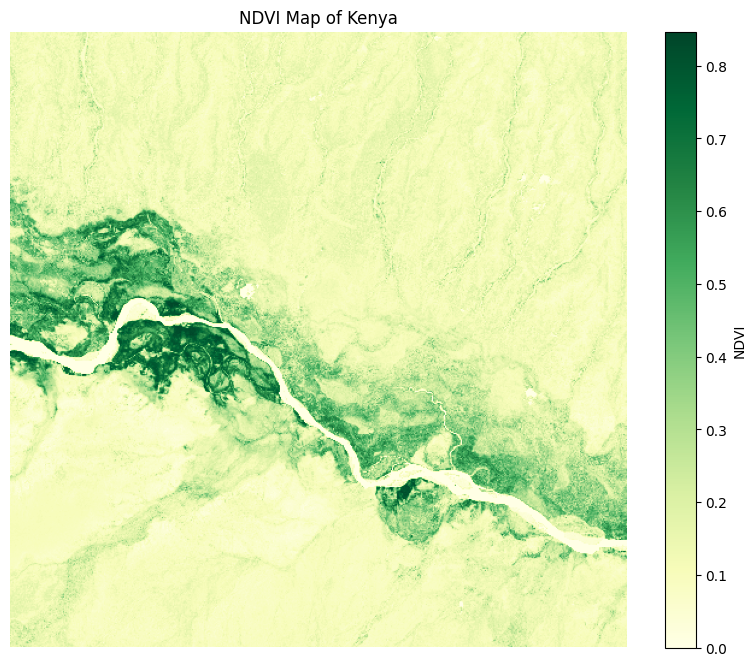

In [13]:
# Create NDVI plot from TIFF

# Load the NDVI TIFF
with rasterio.open("cloud.tiff") as src:
    ndvi = src.read(1)
    ndvi = np.where(ndvi == src.nodata, np.nan, ndvi)  # Mask nodata values

# Normalize to [0, 1] if not already
ndvi_normalized = np.clip(ndvi, 0, 1)

# Create plot
plt.figure(figsize=(10, 8))
cmap = colormaps["YlGn"]
im = plt.imshow(ndvi_normalized, cmap=cmap)
plt.title("NDVI Map of Kenya")
plt.colorbar(im, label="NDVI")
plt.axis('off')
plt.savefig("NDVI-fig.png")
plt.show()


In [14]:
# Create HTML file with NDVI visualization on map.

# Define bounding box (adjust as needed)
bounding_box = {
    'north': 0.006498117499101688,
    'south': -0.1731641174991017,
    'west': 39.02616878748726,
    'east': 39.20583121251274
}

# Load NDVI mosaic
ndvi_mosaic = rasterio.open("ndvi_tiles/kenya_ndvi_merged.tif")
ndvi_data = ndvi_mosaic.read(1)

# Normalize NDVI (-1 to 1 -> 0 to 1 for display)
ndvi_normalized = np.clip(ndvi_data, 0, 1)

# Apply colormap
cmap = colormaps["YlGn"]
img_rgb = cmap(ndvi_normalized)[:, :, :3]
img_pil = Image.fromarray((img_rgb * 255).astype(np.uint8))

# Save image temporarily
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp_file:
    tmp_file_path = tmp_file.name
    img_pil.save(tmp_file_path)

# Setup folium map
center_lat = (bounding_box['north'] + bounding_box['south']) / 2
center_lon = (bounding_box['west'] + bounding_box['east']) / 2
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Add NDVI overlay
raster_layers.ImageOverlay(
    image=tmp_file_path,
    bounds=[[bounding_box['south'], bounding_box['west']],
            [bounding_box['north'], bounding_box['east']]],
    opacity=0.6
).add_to(m)

# Get map ID to properly reference it in JS
map_id = m.get_name()

# Safely convert NDVI array to JSON
ndvi_json = json.dumps(ndvi_data.tolist())

# Add JavaScript for interactivity
click_js = f"""
<script>
const ndviArray = {ndvi_json};

function latLonToPixel(lat, lon) {{
    const width = {ndvi_data.shape[1]};
    const height = {ndvi_data.shape[0]};
    const south = {bounding_box['south']};
    const north = {bounding_box['north']};
    const west = {bounding_box['west']};
    const east = {bounding_box['east']};

    const x = Math.floor((width * (lon - west)) / (east - west));
    const y = Math.floor((height * (north - lat)) / (north - south));
    return [x, y];
}}

{map_id}.on('click', function(e) {{
    const lat = e.latlng.lat;
    const lon = e.latlng.lng;
    const [x, y] = latLonToPixel(lat, lon);

    if (x >= 0 && x < ndviArray[0].length && y >= 0 && y < ndviArray.length) {{
        const ndvi = ndviArray[y][x];
        L.popup()
            .setLatLng(e.latlng)
            .setContent("NDVI: " + ndvi.toFixed(3))
            .openOn({map_id});
    }}
}});
</script>
"""

# Add the custom JS to the map
m.get_root().html.add_child(Element(click_js))

# Save
m.save("map_with_overlay.html")
print("✅ NDVI interactive map saved to 'map_with_overlay.html'")


NameError: name 'Element' is not defined

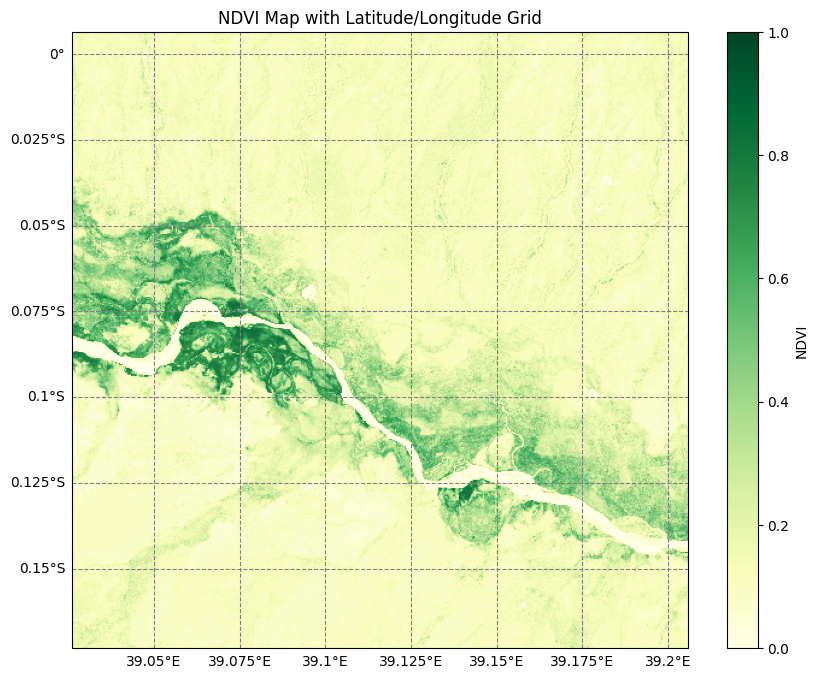

In [15]:
# Creates NDVI map with lat long overlay

# Load the NDVI TIFF file
with rasterio.open("cloud.tiff") as src:
    ndvi = src.read(1)
    bounds = src.bounds
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

# Plot NDVI with lat/lon grid
ndvi = np.clip(ndvi, 0, 1)
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
img = ax.imshow(ndvi, extent=extent, origin='upper', transform=ccrs.PlateCarree(), cmap='YlGn', vmin=0, vmax=1)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray')
gl.top_labels = gl.right_labels = False

ax.set_title("NDVI Map with Latitude/Longitude Grid")
plt.colorbar(img, ax=ax, orientation='vertical', label='NDVI')
plt.savefig("NDVI-fig-lat.png")
plt.show()


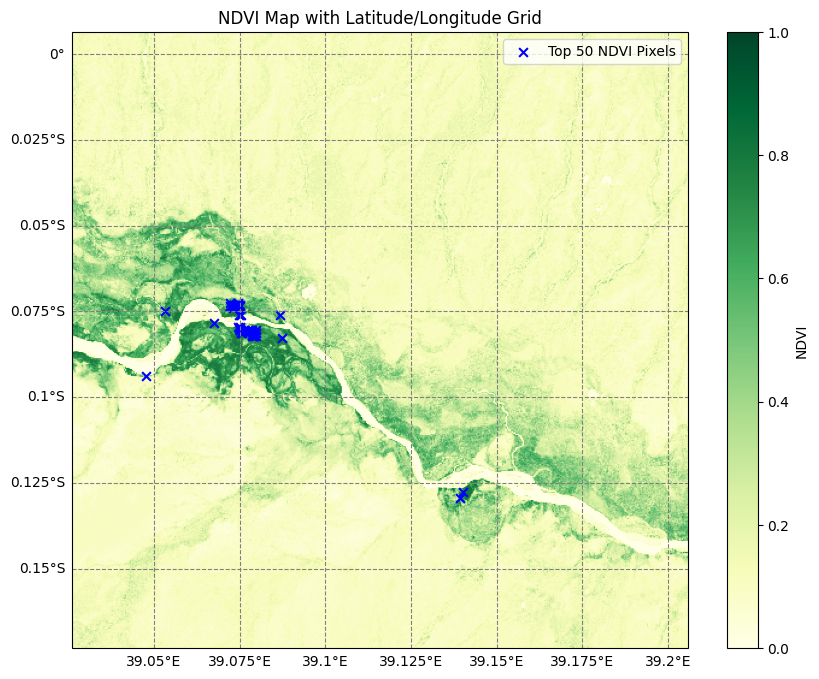

In [16]:
# Creates NDVI map with lat long overlay and 50 highest NDVI pixels highlighted

# Load the NDVI TIFF file
with rasterio.open("cloud.tiff") as src:
    ndvi = src.read(1)
    bounds = src.bounds
    transform = src.transform
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

# Clip NDVI values to 0–1 range
ndvi_clipped = np.clip(ndvi, 0, 1)

# Find the 50 highest NDVI pixels
flat_indices = np.argpartition(ndvi_clipped.ravel(), -50)[-50:]
row_indices, col_indices = np.unravel_index(flat_indices, ndvi_clipped.shape)

# Convert pixel indices to geographic coordinates
lons, lats = zip(*[xy(transform, row, col) for row, col in zip(row_indices, col_indices)])

# Plot NDVI with lat/lon grid
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
img = ax.imshow(ndvi_clipped, extent=extent, origin='upper',
                transform=ccrs.PlateCarree(), cmap='YlGn', vmin=0, vmax=1)

# Overlay highest NDVI points
ax.scatter(lons, lats, color='blue', marker='x', s=40, label='Top 50 NDVI Pixels')

# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray')
gl.top_labels = gl.right_labels = False

ax.set_title("NDVI Map with Latitude/Longitude Grid")
plt.colorbar(img, ax=ax, orientation='vertical', label='NDVI')
plt.legend()
plt.savefig("NDVI-fig-lat-top50.png")
plt.show()
